In [5]:
# Base import and functions

import imutils
import cv2
from imutils import contours
import os, os.path

from tqdm import tqdm

import pytesseract             # Python interface to tesseract for OCR

import numpy as np
from PIL import Image

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [13]:
def build_segmentation_row(filesconut, current_file_index, fig, input_src, serial, number, barcode):
    
    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 1)
    imgplot = plt.imshow(cv2.cvtColor(input_src, cv2.COLOR_BGR2RGB))
    a.set_title('Original')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 2)
    imgplot = plt.imshow(cv2.cvtColor(serial, cv2.COLOR_GRAY2RGB))
    a.set_title('Serial')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 3)
    imgplot = plt.imshow(cv2.cvtColor(number, cv2.COLOR_GRAY2RGB))
    a.set_title('Number')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 4)
    imgplot = plt.imshow(cv2.cvtColor(barcode, cv2.COLOR_GRAY2RGB))
    a.set_title('Barcode')
    
def build_contoured_row(filesconut, current_file_index, fig, input_src, serial, number, barcode):
    
    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 1)
    imgplot = plt.imshow(cv2.cvtColor(input_src, cv2.COLOR_BGR2RGB))
    a.set_title('Original')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 2)
    imgplot = plt.imshow(cv2.cvtColor(serial, cv2.COLOR_BGR2RGB))
    a.set_title('Serial')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 3)
    imgplot = plt.imshow(cv2.cvtColor(number, cv2.COLOR_BGR2RGB))
    a.set_title('Number')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 4)
    imgplot = plt.imshow(cv2.cvtColor(barcode, cv2.COLOR_GRAY2RGB))
    a.set_title('Barcode')

CPU times: user 113 ms, sys: 43 µs, total: 113 ms
Wall time: 83.2 ms


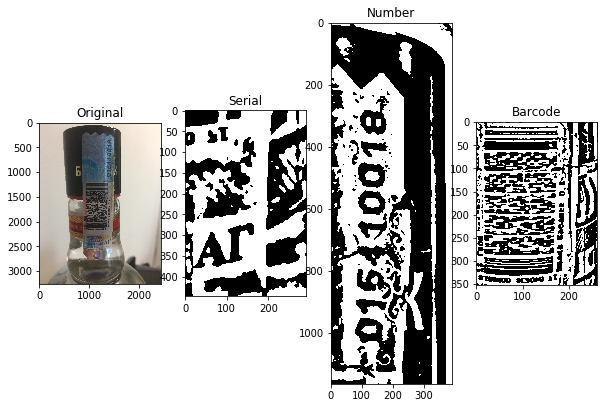

In [21]:
def excise_segmentation(image):
    
    number = image[78:78+1166, 1276:1276+392]
    serial = image[2088:2088+448, 1276:1276+292]
   
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    # Serial
    hsv_image = cv2.cvtColor(serial, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    v = clahe.apply(v)
    blurred = cv2.bilateralFilter(v, 9, 75, 75)
    blurred = cv2.medianBlur(blurred, 5)
    serial_thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 255, 1)
    
    edged = cv2.Canny(serial_thresholded, 30, 200)
    refCnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    serial_contours = np.dstack([serial_thresholded.copy()] * 3)
    for c in refCnts:
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(serial_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Number
    hsv_image = cv2.cvtColor(number, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    v = clahe.apply(v)
    blurred = cv2.bilateralFilter(v, 9, 75, 75)
    blurred = cv2.medianBlur(blurred, 5)
    number_thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 195, 1)
    
    edged = cv2.Canny(number_thresholded, 30, 200)
    refCnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    number_contours = np.dstack([number_thresholded.copy()] * 3)
    for c in refCnts:
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(number_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Barcode
    barcode_thresholded = image[880:880+1408, 828:828+868]
    barcode = imutils.resize(image[880:880+1408, 828:828+868], height=500)
    hsv_image = cv2.cvtColor(barcode, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    gray = clahe.apply(v)
    gradX = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
    gradY = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)
    blurred = cv2.medianBlur(gradient, 11)
    (_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    morph = cv2.erode(closed, None, iterations = 11)
    cnts = cv2.findContours(morph.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    if len(cnts):
        c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
        (x, y, w, h) = cv2.boundingRect(c)
        # PDF417 correction
        x = x - 10 if (x > 10) else 0
        w = w + 20 if (w < 868 - x - 20) else 868 - x
        # Top and bottom black line in PDF417
        y = y - (int)(0.3 * h) if (y > 0.3 * h) else 0
        h = h + (int)(0.5 * h) if (h < 1408 - y - (int)(0.6 * h)) else 1408 - y        
        hsv_image = cv2.cvtColor(barcode[y:y+h, x:x+w], cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv_image)
        gray = clahe.apply(v)
        blured = cv2.medianBlur(gray, 3)
        barcode_thresholded = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 1)        
 
    # return the segmentationed images
    return serial_thresholded, number_thresholded, barcode_thresholded
    # return serial_contours, number_contours, barcode_thresholded
    # return serial_thresholded, number_contours, barcode_thresholded

# excise_src = cv2.imread("data/premasked/IMG_0676.JPG")
excise_src = cv2.imread("data/premasked/IMG_0549.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0560.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0562.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0595.JPG")
filescount = 1
current_file_index = 0
fig = plt.figure(figsize=(10, 200))
%time serial_thresholded, number_thresholded, barcode_thresholded = excise_segmentation(excise_src)

build_segmentation_row(filescount, current_file_index, fig, excise_src, serial_thresholded, number_thresholded, barcode_thresholded)
# build_contoured_row(filescount, current_file_index, fig, excise_src, serial_thresholded, number_thresholded, barcode_thresholded)

plt.show()

## Gaussian Mixture Model

A Gaussian Mixture Model (GMM) is a parametric probability density function represented as a weighted sum of Gaussian component densities. GMMs are commonly used as a parametric model of the probability distribution of continuous measurements or features. Here the GMM parameters are estimated from the training data using the iterative Expectation Maximization (EM) algorithm and RGB values are used as features.

### Algorithm
- Initialize all the gaussians (3 in this case) with their respective means, variances and mixing coefficients (weights). Each gaussian will represent one cluster.
- Evaluate the reponsibilities using current parameters.
- Re-estimate the parameters using current responsibilities.
- Evaluate the log likelihood.
- Check for convergence of either log likelihood or parameters.

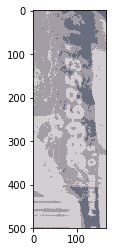

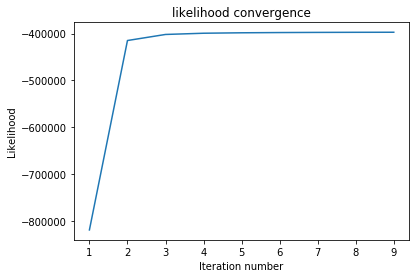

CPU times: user 29 s, sys: 504 ms, total: 29.5 s
Wall time: 28.9 s


In [81]:
%%time

import glob, os
from PIL import Image 
import numpy as np
import PIL
from matplotlib import pyplot

# reading image into matrix

src = Image.open('data/premasked/IMG_0676.JPG')
# src = Image.open('data/premasked/IMG_0549.JPG')
# src = Image.open('data/premasked/IMG_0560.JPG')
# src = Image.open('data/premasked/IMG_0562.JPG')
# src = Image.open('data/premasked/IMG_0595.JPG')

img = src.rotate(-90, expand=True).crop((1276, 78, 1276+392, 78+1166))
width = img.size[0]
height = img.size[1]
img = img.resize(((int)(width * 500 / height), 500), Image.ANTIALIAS)
pixels = np.asarray(((img.getdata())))

width = img.size[0]
height = img.size[1]

#total no of pixels
N = height * width;

# initializing means, variances and weights
feat = pixels
v = [0,1,2]
val = 250
mean = [np.array([120, 120, 120]), np.array([12, 12, 12]), np.array([180, 180, 180])]
var = [val*np.identity(3), val*np.identity(3), val*np.identity(3)]

weights = [float(1/3), float(1/3), float(1/3)]

# gaussian function
def gau(mean, var, varInv, feature):
    a = np.sqrt(2*np.pi**3)
    b = np.exp(-0.5*np.dot((feature-mean), np.dot(varInv, (feature-mean).transpose())))
    return b/a

# calculating responsibilities    
def res(likelihoods):
    tempList = []
    for comp in likelihoods:
        tempList.append(comp/sum(likelihoods))
    return tempList

# calculating likelihoods
def likeli(mean, var, varInv, weights, feature):
    temp = []
    for x in v:
        temp.append(weights[x]*gau(mean[x], var[x], varInv[x], feature))
    return temp
	

varInv = [np.linalg.inv(var[0]), np.linalg.inv(var[1]), np.linalg.inv(var[2])]
meanPrev = [np.array([0, 0, 0]), np.array([0, 0, 0]), np.array([0, 0, 0])]
iteration = []
logLikelihoods = []
counterr = 0

# iterating until convergence is reached
while sum(sum(np.absolute(np.asarray(mean) - np.asarray(meanPrev)))) >= 3:
    resp = []
    likelihoods = []
    for feature in feat:
        classLikelihoods = likeli(mean, var, varInv, weights, feature)
        rspblts = res(classLikelihoods)
        likelihoods.append(sum(classLikelihoods))
        resp.append(rspblts)
    logLikelihoods.append(sum(np.log(likelihoods)))
    nK = [sum(np.asarray(resp)[:,0:1]), sum(np.asarray(resp)[:,1:2]), sum(np.asarray(resp)[:,2:3])]
    weights = [float(nK[0]/N), float(nK[1]/N), float(nK[2]/N)]
    meanIterator =  np.dot(np.asarray(resp).T, feat)
    meanPrev = mean
    mean = [meanIterator[0]/nK[0], meanIterator[1]/nK[1], meanIterator[2]/nK[2]]
    counterr += 1
    iteration.append(counterr)

resp = []
for feature in feat:
    classLikelihoods = likeli(mean, var, varInv, weights, feature)
    rspblts = res(classLikelihoods)
    resp.append(rspblts)
	
result = []
counter = 0
segmentedImage = np.zeros((N, np.shape(img)[2]), np.uint8)

# assigning values to pixels of different segments                          
for response in resp:
    maxResp = max(response)
    respmax = response.index(maxResp)
    result.append(respmax)
    segmentedImage[counter] = mean[respmax]
    counter = counter + 1

blue0 = segmentedImage[:,0]
green0 = segmentedImage[:,1]
red0 = segmentedImage[:,2]

# rgb values of all the pixels segmented according to gaussian models
blue = np.reshape(blue0.flatten(), (np.shape(img)[0],np.shape(img)[1]))
green = np.reshape(green0.flatten(), (np.shape(img)[0],np.shape(img)[1]))
red = np.reshape(red0.flatten(), (np.shape(img)[0],np.shape(img)[1]))

recns = np.zeros((height, width, 3))

for i in range(height):
    for j in range(width):
        recns[i][j] = np.array([blue[i][j], green[i][j], red[i][j]])

# plotting segmented image
pyplot.imshow(recns)
pyplot.show()			

# plotting the graph of likelihood versus number of iterations
pyplot.plot(iteration, logLikelihoods)
pyplot.title('likelihood convergence')
pyplot.ylabel('Likelihood')
pyplot.xlabel('Iteration number')

# Show the figure.
pyplot.show()

# Grate, But a bit slow (30 second in 500 pixeled height)
### The method can be used and optimized, but first we'll try the rest of the segmentation